### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [2]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [3]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [4]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [5]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

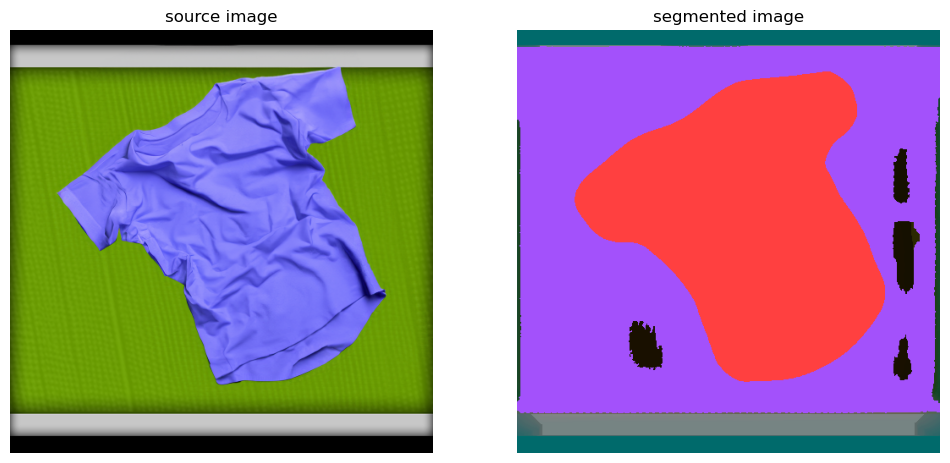

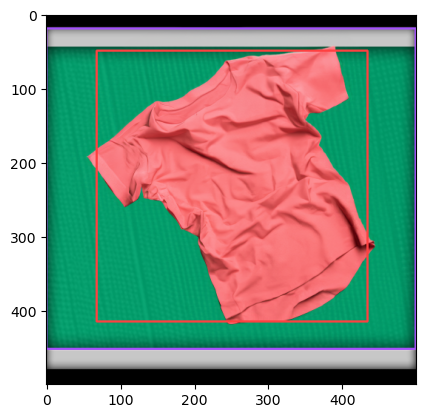

In [26]:
relative_path = get_training_data_path('production', 'tshirt')

file_names = []


# Iterate over files in the current directory
for i in range(0, 1):
    fullpath = os.path.join(relative_path, '20240526_154953.png')

    orig_image = Image.open(fullpath)
    orig_image = orig_image.rotate(0)
    #image = erase_generator(path=fullpath)
    n_image = np.array(orig_image)
    # Convert image to YCrCb color space, then apply blurring and shadow removal
    image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)


    blurred_image = cv2.medianBlur(image_ycrcb, 51)
    processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

    # Generate masks and filter them
    masks = mask_generator.generate(blurred_image)
    cleaned_masks = [mask for mask in masks if mask['area'] > 25000]

    # Annotation of the image
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
    detections = sv.Detections.from_sam(sam_result=cleaned_masks)
    annotated_image = mask_annotator.annotate(scene=processed_image.copy(), detections=detections)
    
    # Displaying images
    sv.plot_images_grid(
        images=[n_image, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

    # Bounding box annotation on the original image for consistency
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    final_annotated_image = bounding_box_annotator.annotate(
        scene=orig_image, detections=detections)

    plt.imshow(final_annotated_image)

82597


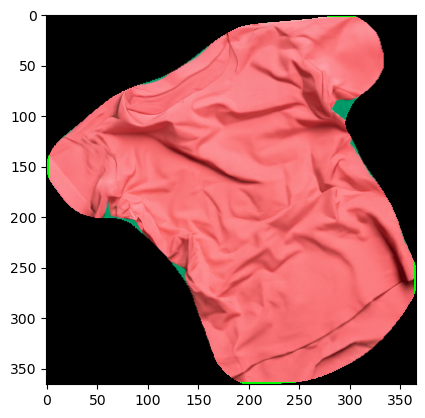

In [27]:
masks_cleaned = []
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 100000):
        masks_cleaned.append(mask)

masked_image = n_image
x, y, w, h = cleaned_masks[0]['bbox']
print(cleaned_masks[0]['area'])
cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)
cropped_image = masked_image[y:y+h, x:x+w]


#plt.imshow(cropped_image)

cropped_mask = cleaned_masks[0]['segmentation'][y:y+h,x:x+w]
cropped_mask = cropped_mask.astype(np.uint8) * 255
masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=cropped_mask)

plt.imshow(masked_image)

In [30]:
blueprint_img = cv2.imread('masked_tshirt_blueprint.png', cv2.IMREAD_GRAYSCALE)

# Threshold to create a binary mask
_, blueprint_mask = cv2.threshold(blueprint_img, 128, 255, cv2.THRESH_BINARY)


cropped_mask = cv2.resize(cropped_mask, (256, 256))


In [31]:
rotated_masks = []
angle_step = 10
for angle in range(0, 360, angle_step):
    (h, w) = cropped_mask.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(cropped_mask, M, (w, h), flags=cv2.INTER_NEAREST)
    rotated_masks.append(rotated)

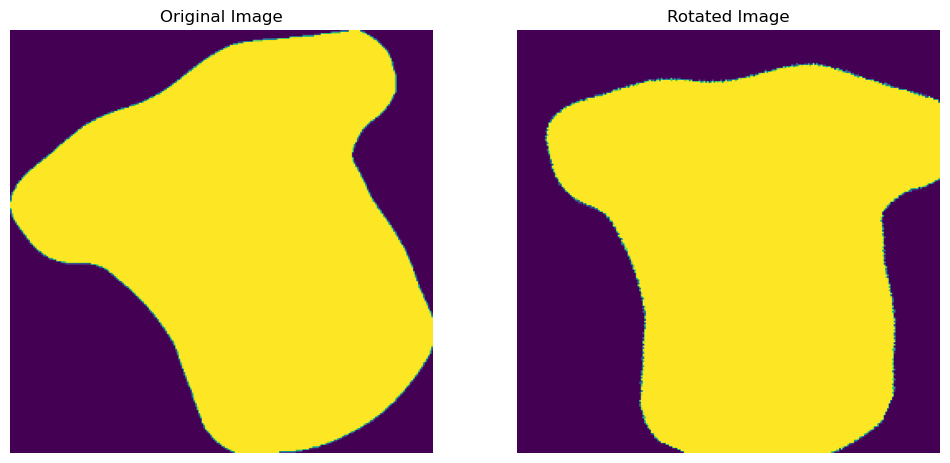

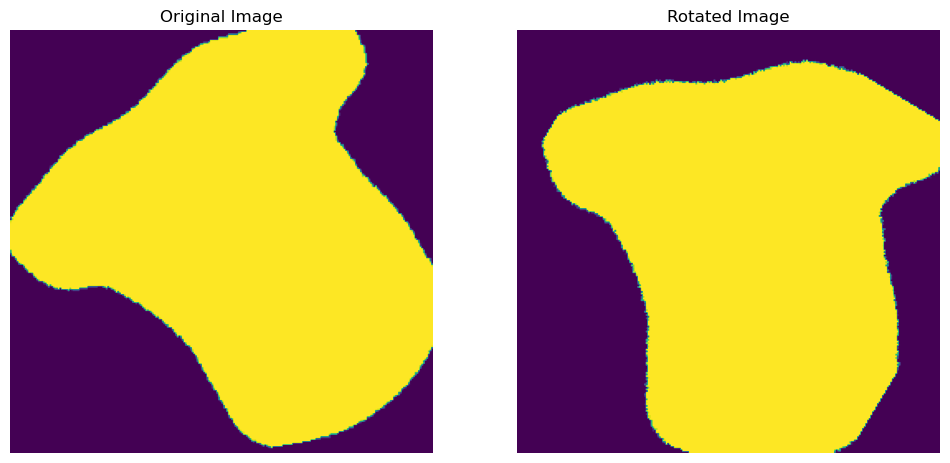

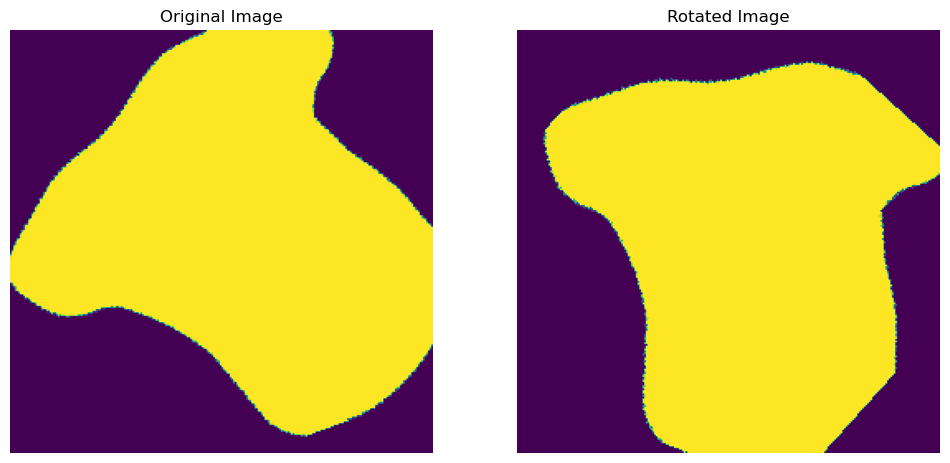

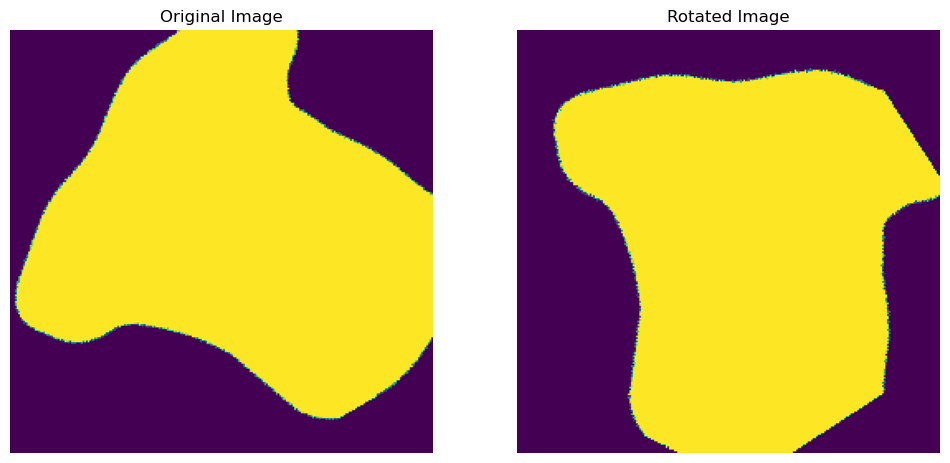

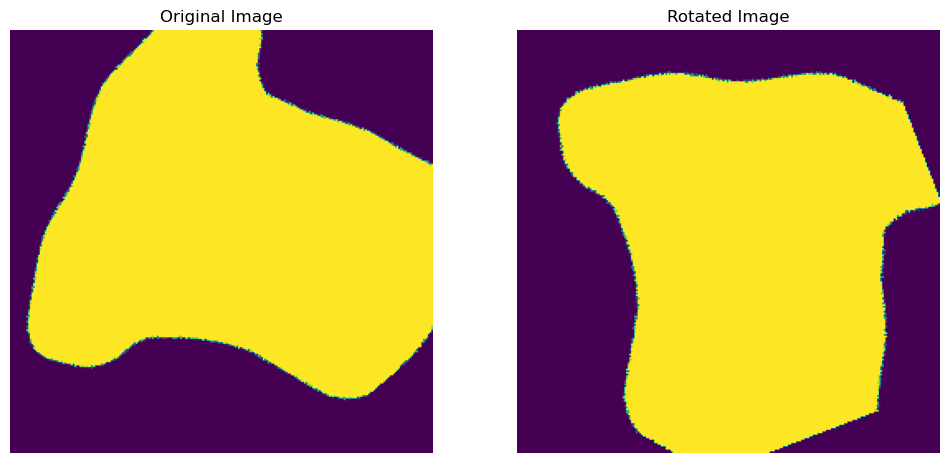

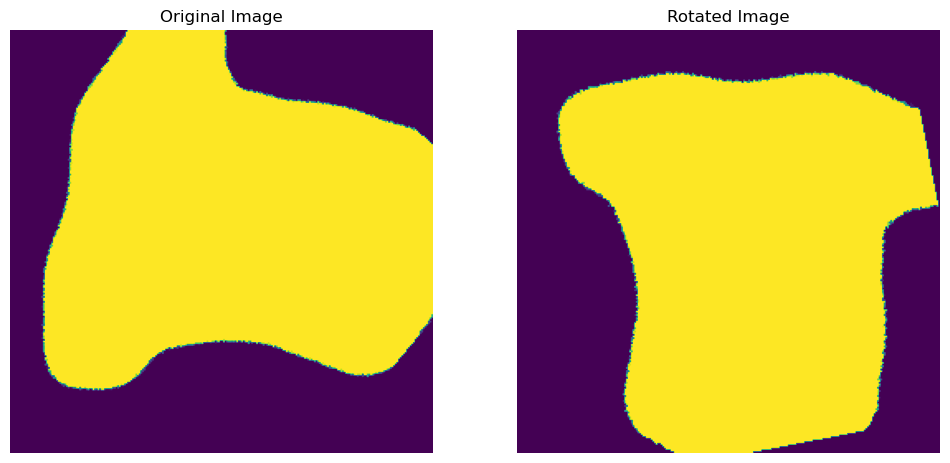

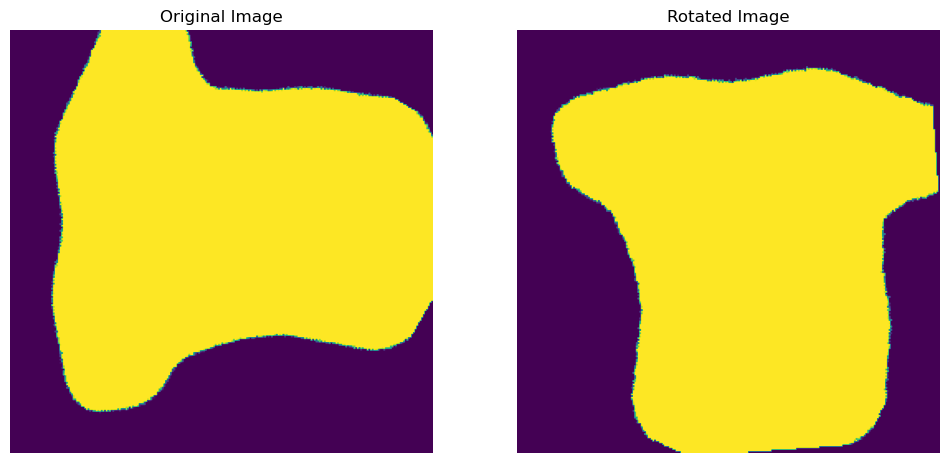

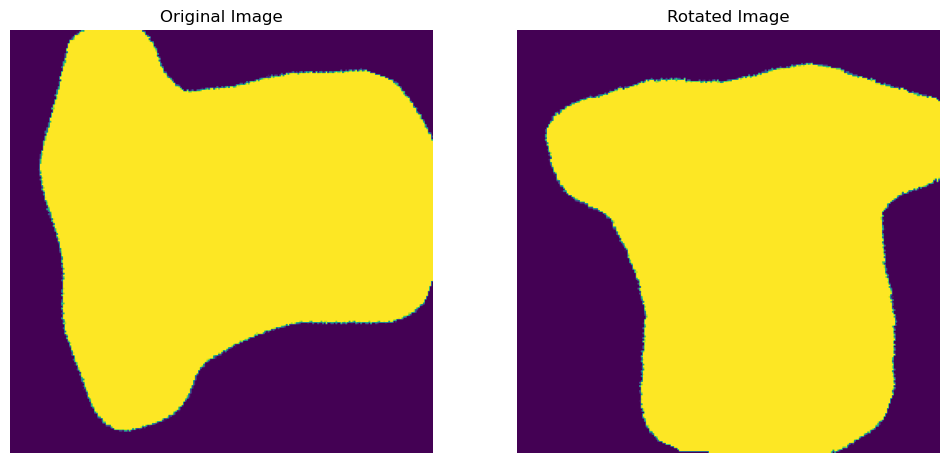

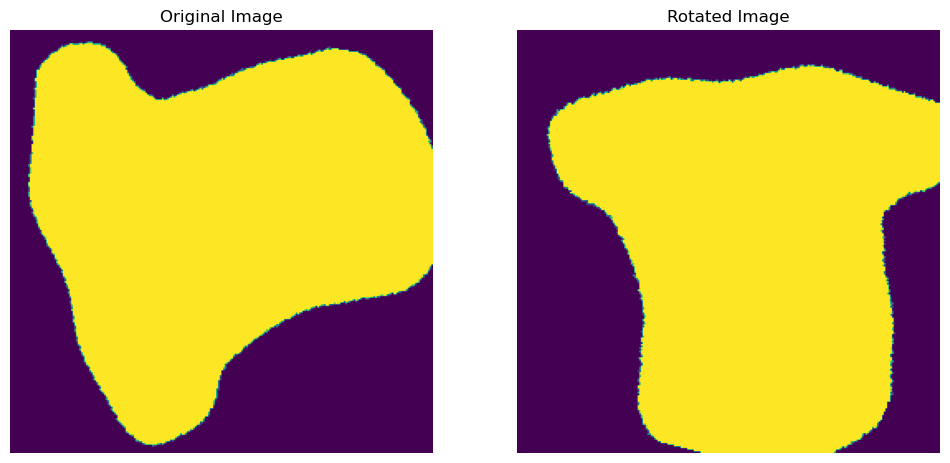

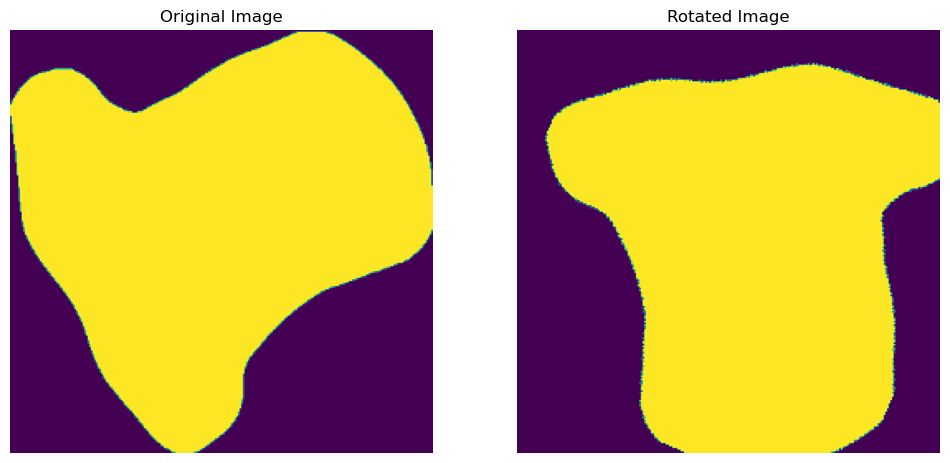

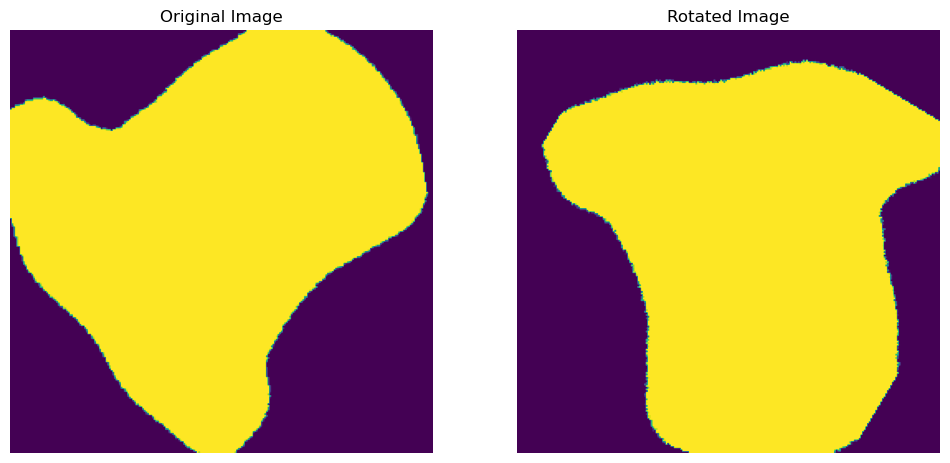

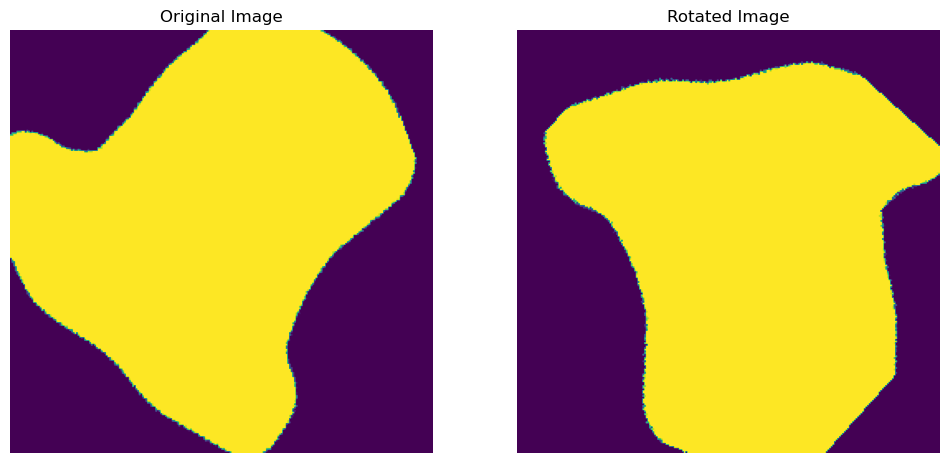

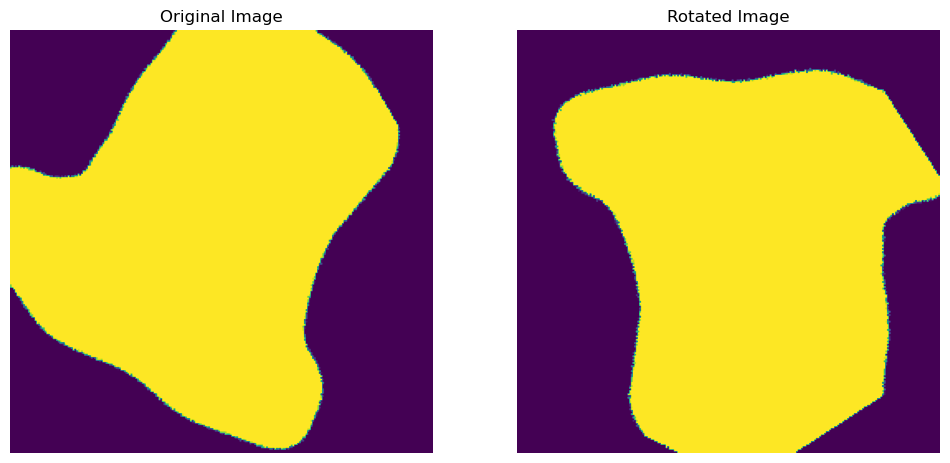

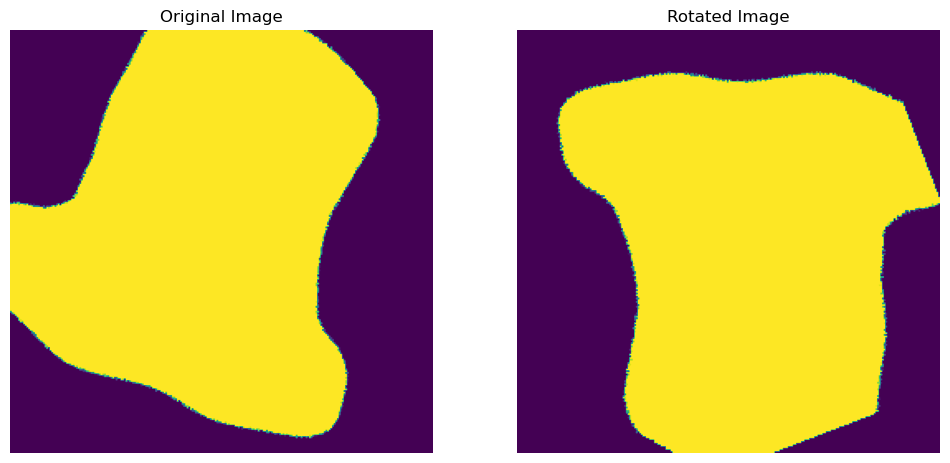

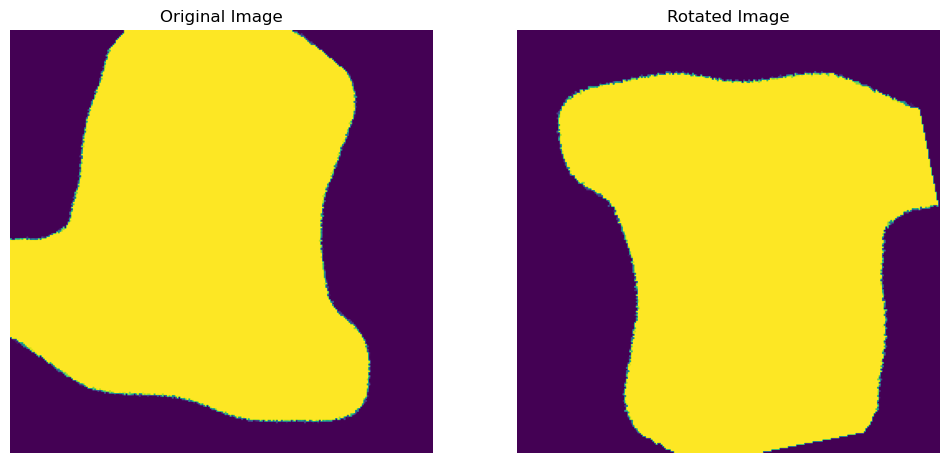

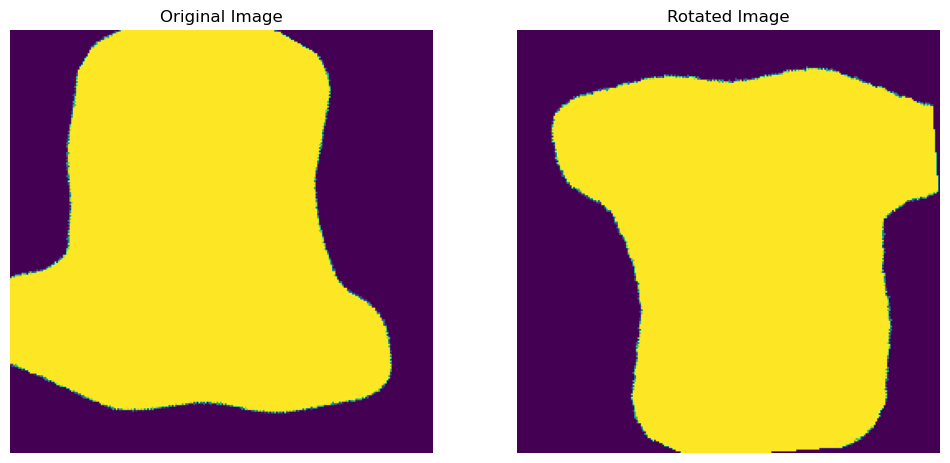

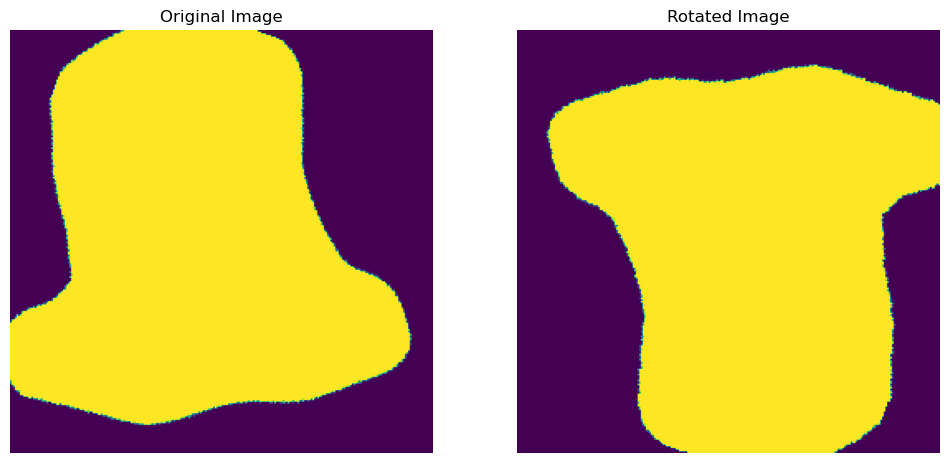

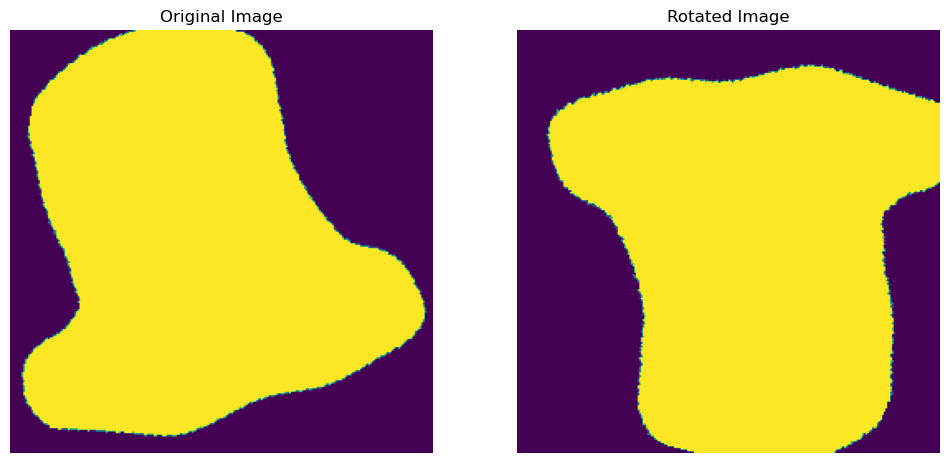

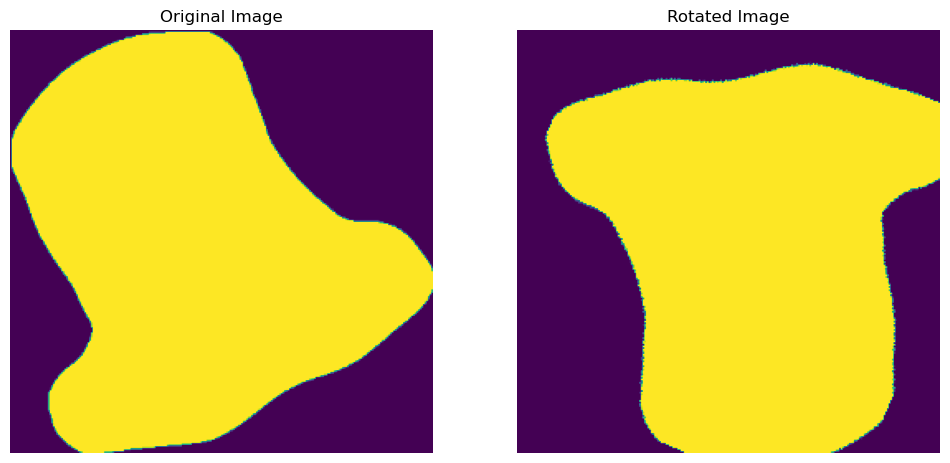

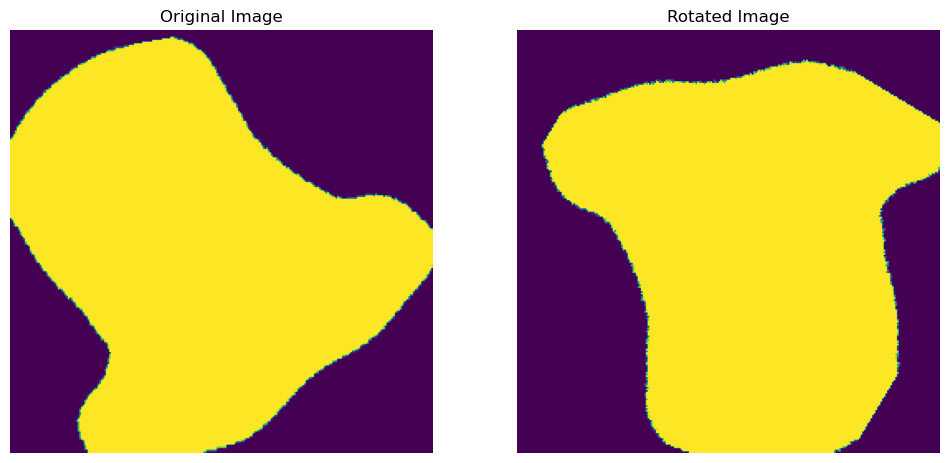

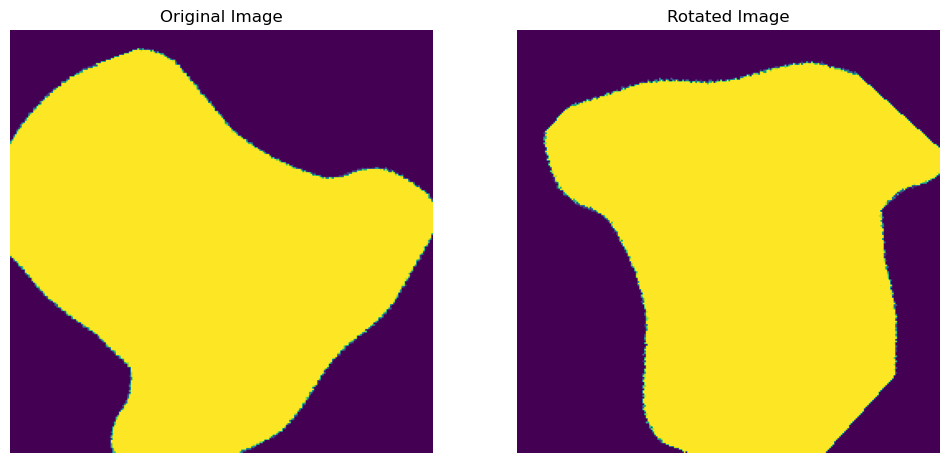

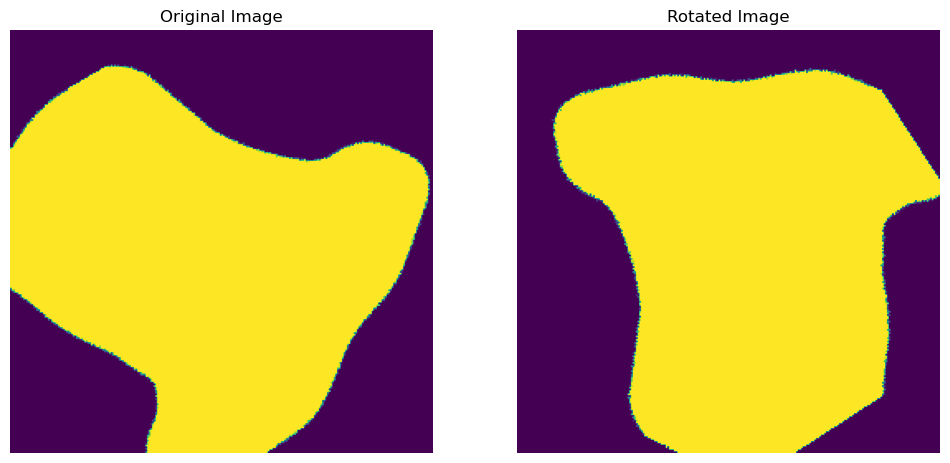

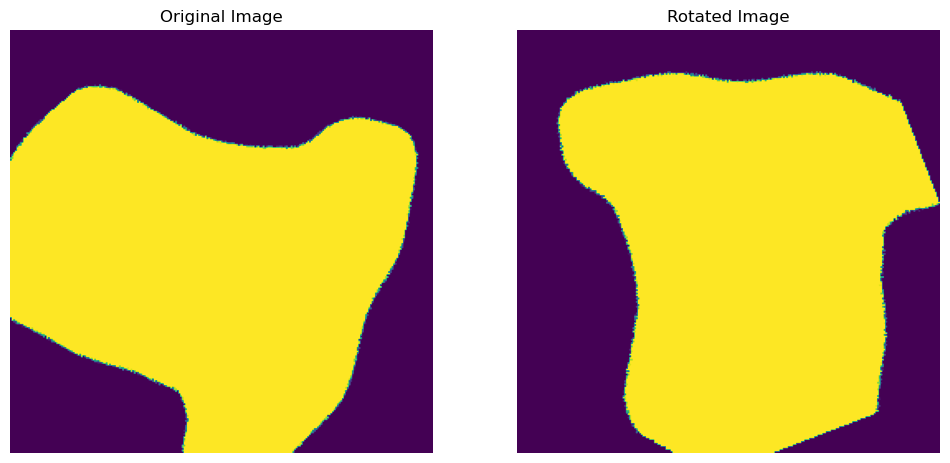

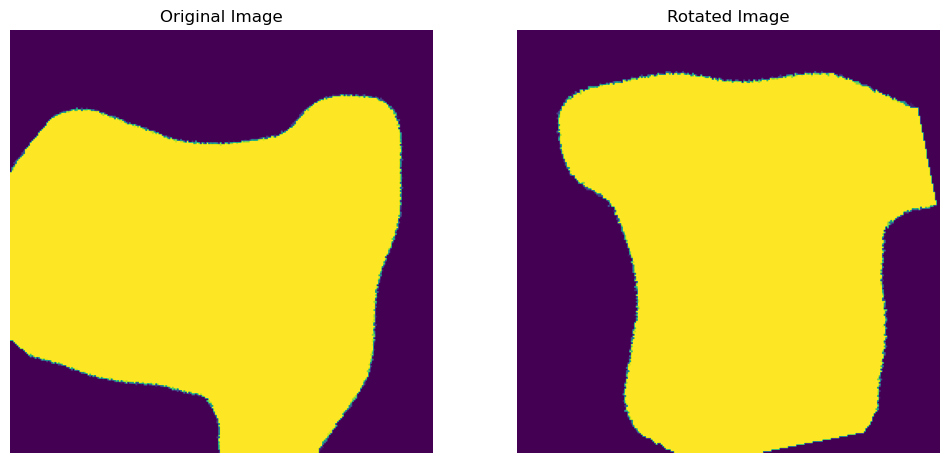

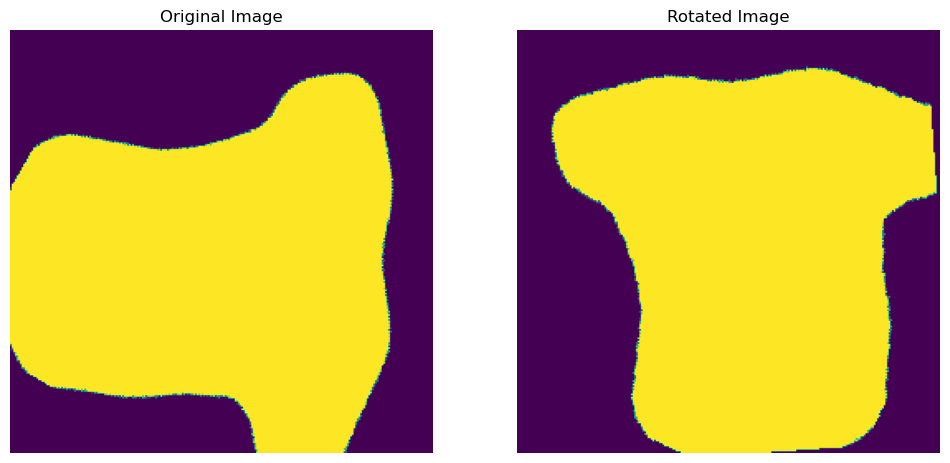

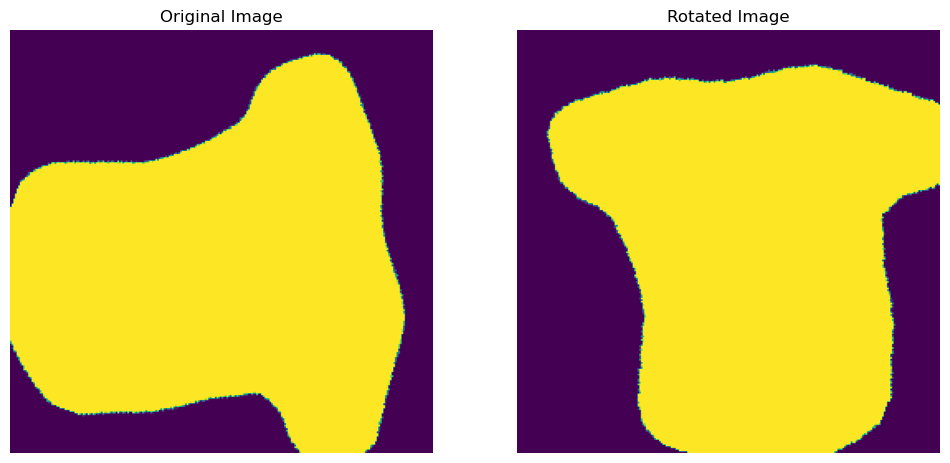

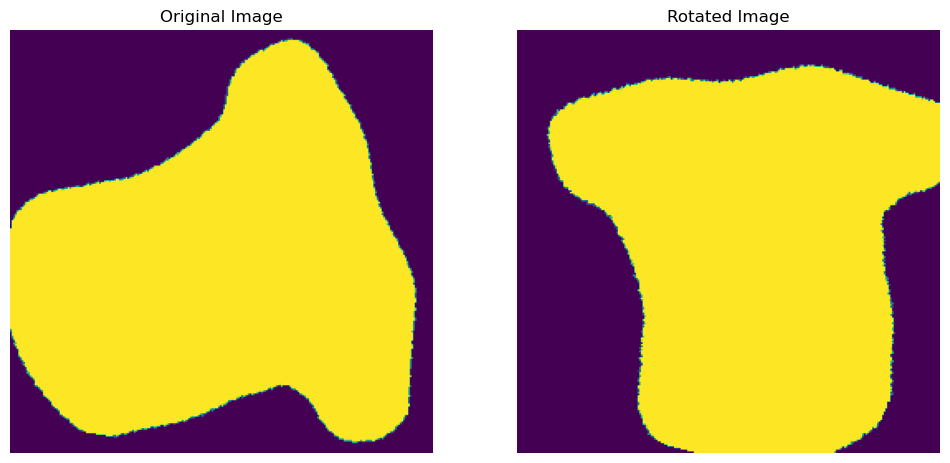

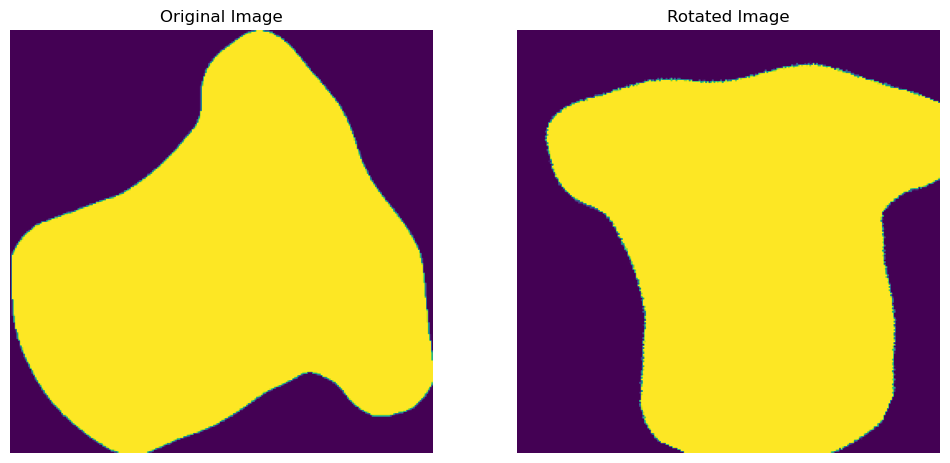

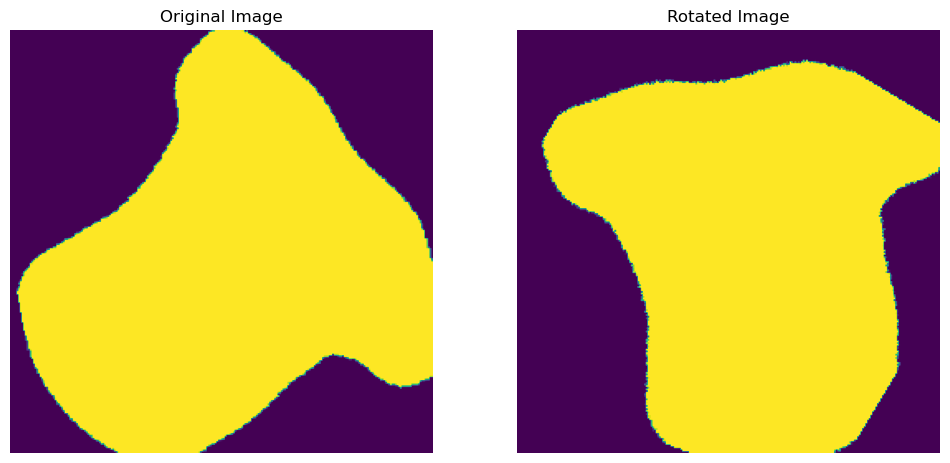

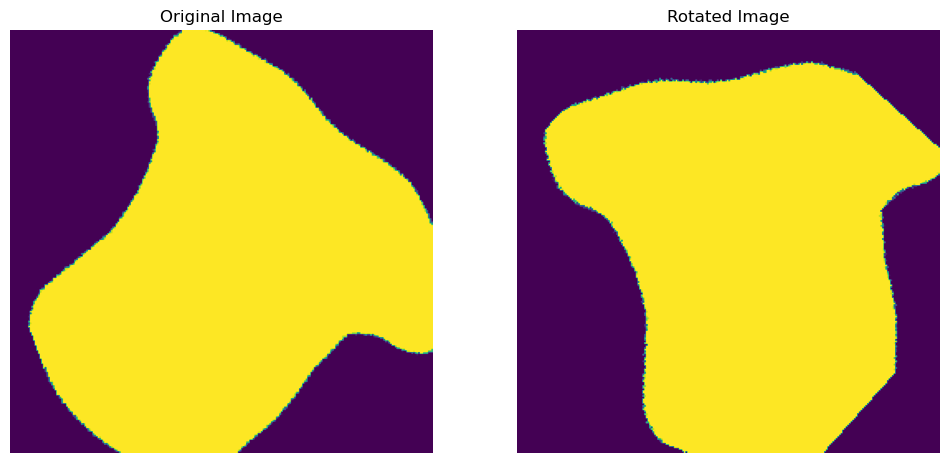

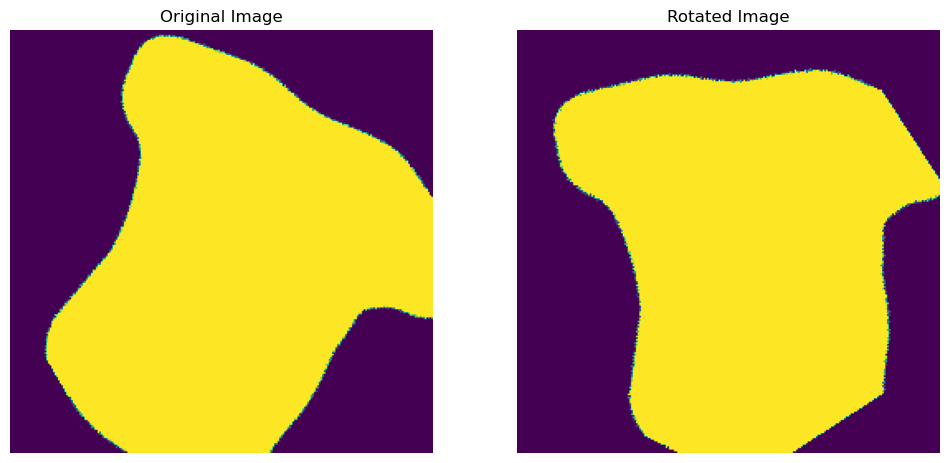

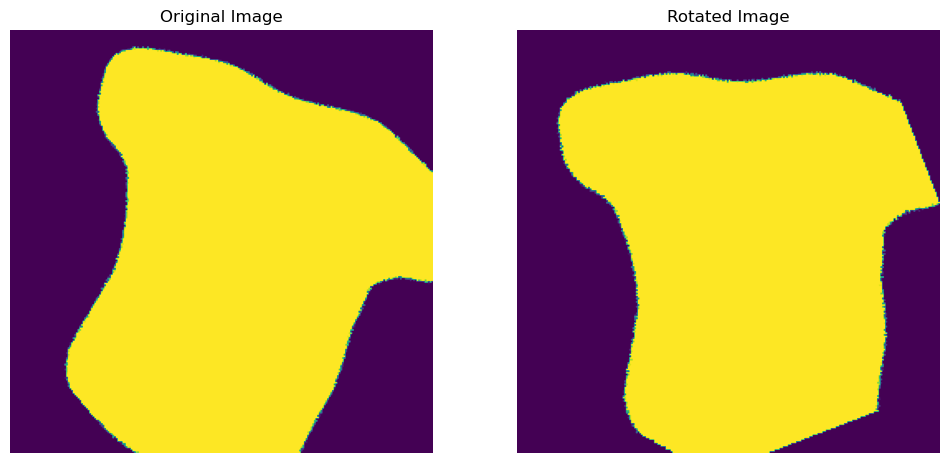

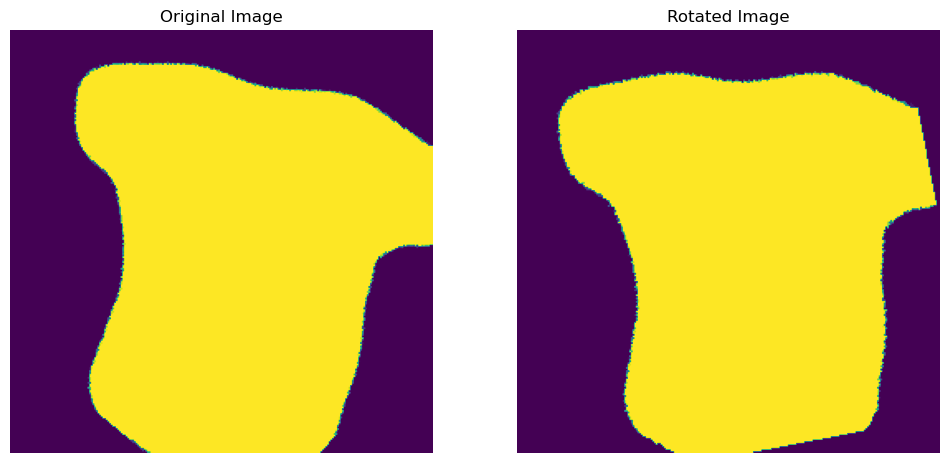

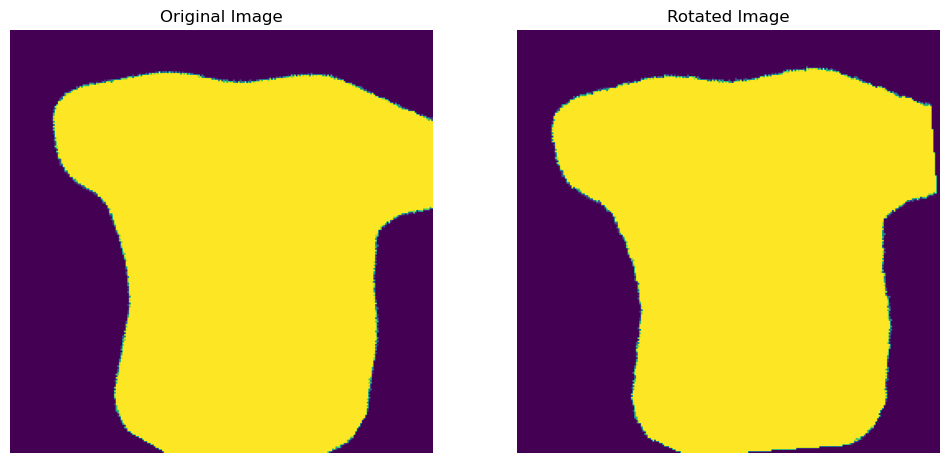

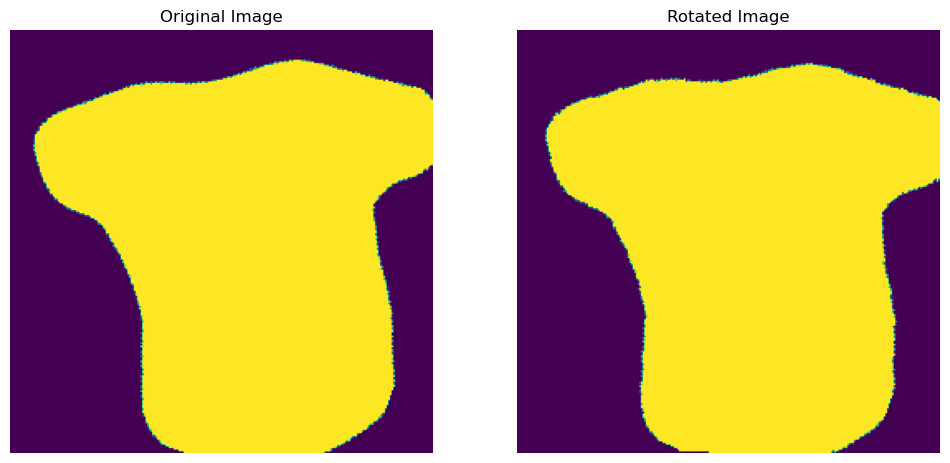

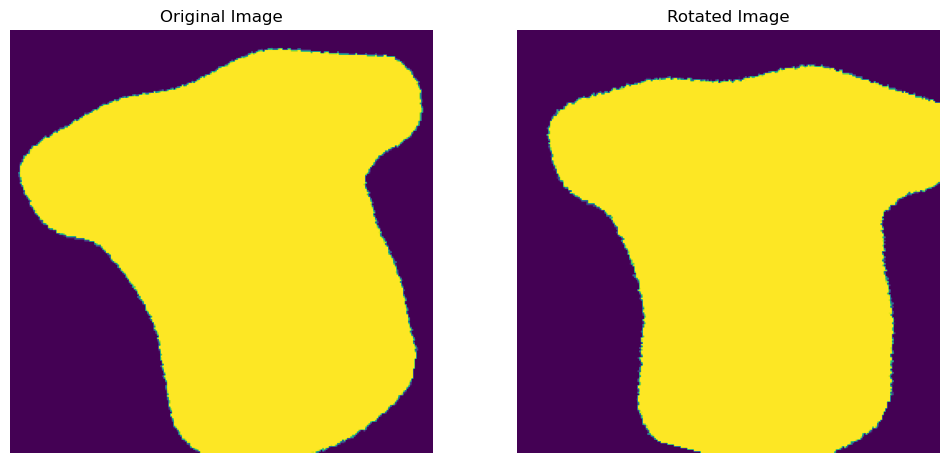

In [32]:
def compute_overlap(mask1, mask2):
    # Compute the overlapping area between two binary masks
    overlap = np.sum((mask1 == 255) & (mask2 == 255))
    return overlap

def find_best_rotation(input_mask, blueprint_mask, angle_step=1):
    best_angle = 0
    max_overlap = 0
    
    for angle in range(0, 360, angle_step):
        # Rotate the input mask
        rotated_mask = rotate_image(input_mask, angle)
        
        # Compute the overlap with the blueprint mask
        overlap = compute_overlap(rotated_mask, blueprint_mask)
        if overlap > max_overlap:
            max_overlap = overlap
            best_angle = angle
            
    return best_angle

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST)
    return rotated

    plt.figure(figsize=(12, 6))

for mask in rotated_masks:
    # Find the best rotation angle
    best_angle = find_best_rotation(mask, blueprint_mask)
    #print(f'Best rotation angle: {best_angle}')
    aligned_image = rotate_image(mask, best_angle)
    plt.figure(figsize=(12, 6))


    plt.subplot(121)
    plt.imshow(mask)
    plt.title('Original Image')
    plt.axis('off')


    plt.subplot(122)
    plt.imshow(aligned_image)
    plt.title('Rotated Image')
    plt.axis('off')
